# setup

In [1]:
import torch
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  mydrive='/content/drive/MyDrive/volrt/'
  source_path=mydrive+"git/Crossformer"
  tables = ['volvN.csv', 'volvT.csv', 'volvA.csv', 'volvG.csv', ]
  batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*64
  import os,sys
  if not os.path.exists(source_path):
    %cd $mydrive/git
    !git clone https://github.com/jerronl/Crossformer.git
    %cd $source_path
  else:
    %cd $source_path
    !git reset --hard HEAD
    !git pull origin master
  !pip install einops #scikit-learn
  sys.path.append( source_path)
else:
  tables = ['volvA.csv']
  mydrive= 'E:/mydoc/git/trade/analyics/'
  batch_size=32
%cd $mydrive

import argparse
from utils.tools import string_split

parser = argparse.ArgumentParser(description="CrossFormer")

parser.add_argument("--data", type=str, default="vols", help="data")
parser.add_argument(
    "--root_path", type=str, default=mydrive, help="root path of the data file"
)
parser.add_argument("--data_path", type=list, default=tables, help="data file")
parser.add_argument(
    "--data_split",
    type=str,
    default="0.7,0.1,0.2",
    help="train/val/test split, can be ratio or number",
)
parser.add_argument(
    "--checkpoints",
    type=str,
    default="./checkpoints/",
    help="location to store model checkpoints",
)

parser.add_argument("--in_len", type=int, default=20, help="input MTS length (T)")
parser.add_argument("--out_len", type=int, default=1, help="output MTS length (\tau)")
parser.add_argument("--seg_len", type=int, default=5, help="segment length (L_seg)")
parser.add_argument(
    "--win_size", type=int, default=2, help="window size for segment merge"
)
parser.add_argument(
    "--factor",
    type=int,
    default=10,
    help="num of routers in Cross-Dimension Stage of TSA (c)",
)

parser.add_argument(
    "--data_dim", type=int, default=32, help="Number of dimensions of the MTS data (D)"
)
parser.add_argument(
    "--out_dim", type=int, default=3*4+4+22, help="Number of dimensions of the output"
)
parser.add_argument(
    "--d_model", type=int, default=256, help="dimension of hidden states (d_model)"
)
parser.add_argument(
    "--d_ff", type=int, default=512, help="dimension of MLP in transformer"
)
parser.add_argument("--n_heads", type=int, default=4, help="num of heads")
parser.add_argument("--e_layers", type=int, default=3, help="num of encoder layers (N)")
parser.add_argument("--dropout", type=float, default=0.2, help="dropout")

parser.add_argument(
    "--baseline",
    action="store_true",
    help="whether to use mean of past series as baseline for prediction",
    default=False,
)

parser.add_argument(
    "--num_workers", type=int, default=0, help="data loader num workers"
)
parser.add_argument(
    "--batch_size", type=int, default=32, help="batch size of train input data"
)
parser.add_argument("--train_epochs", type=int, default=20, help="train epochs")
parser.add_argument("--patience", type=int, default=3, help="early stopping patience")
parser.add_argument(
    "--learning_rate", type=float, default=1e-4, help="optimizer initial learning rate"
)
parser.add_argument("--lradj", type=str, default="type1", help="adjust learning rate")
parser.add_argument("--itr", type=int, default=5, help="experiments times")

parser.add_argument(
    "--save_pred",
    action="store_true",
    help="whether to save the predicted future MTS",
    default=False,
)

parser.add_argument("--use_gpu", type=bool, default=True, help="use gpu")
parser.add_argument("--resume", type=bool, default=True, help="resume")
parser.add_argument("--cutday", type=str, default=None, help="resume")
# parser.add_argument("--use_gpu", type=bool, default=False, help="use gpu")
parser.add_argument("--gpu", type=int, default=0, help="gpu")
parser.add_argument(
    "--use_multi_gpu", action="store_true", help="use multiple gpus", default=False
)
parser.add_argument(
    "--devices", type=str, default="0,1,2,3", help="device ids of multile gpus"
)

args = parser.parse_args(args=[])

args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(" ", "")
    device_ids = args.devices.split(",")
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]
    print(args.gpu)

def update_args(itr):
    if args.data in data_parser.keys():
        data_info = data_parser[args.data]
        for k,v in data_info.items():
            args.__setattr__(k,v)
    if isinstance(args.data_split, str) :
        args.data_split = string_split(args.data_split)

    print("Args in experiment:")
    print(args)
    setting = "Crossformer_{}_il{}_ol{}_sl{}_win{}_fa{}_dm{}_nh{}_el{}_itr{}".format(
        args.data,
        args.in_len,
        args.out_len,
        args.seg_len,
        args.win_size,
        args.factor,
        args.d_model,
        args.n_heads,
        args.e_layers,
        itr,
    )
    return setting

E:\mydoc\git\trade\analyics


d:\ProgramData\miniconda3\envs\e1\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# train

In [ ]:
from cross_exp.exp_crossformer import Exp_crossformer
data_parser = {
    "vols": {
        "patience":30,
        "train_epochs":500,
        'data_split':[0.7,0.1,0.2],
        'batch_size':batch_size,
    },
    }

for ii in range(1,args.itr):
  setting=update_args(ii)
  exp = Exp_crossformer(args)   # set experiments
  print(f">>>>>>>start training : {setting}>>>>>>>>>>>>>>>>>>>>>>>>>>")
  exp.train(setting)

  print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
  exp.test(setting, args.save_pred)


# test

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, data_dim=32, out_dim=38, d_model=256, d_ff=512, n_heads=4, e_layers=3, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type1', itr=5, save_pred=False, use_gpu=True, resume=True, cutday='#2024-02-01', gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr0/crossformer.pkl
test 188
mse:0.6009293081673915, mae:0.4443844966689611 [4.44384497e-01 6.00929308e-01 7.63932978e-01 3.53995022e+00
 7.37560664e+02 3.19148936e-01]
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr0/

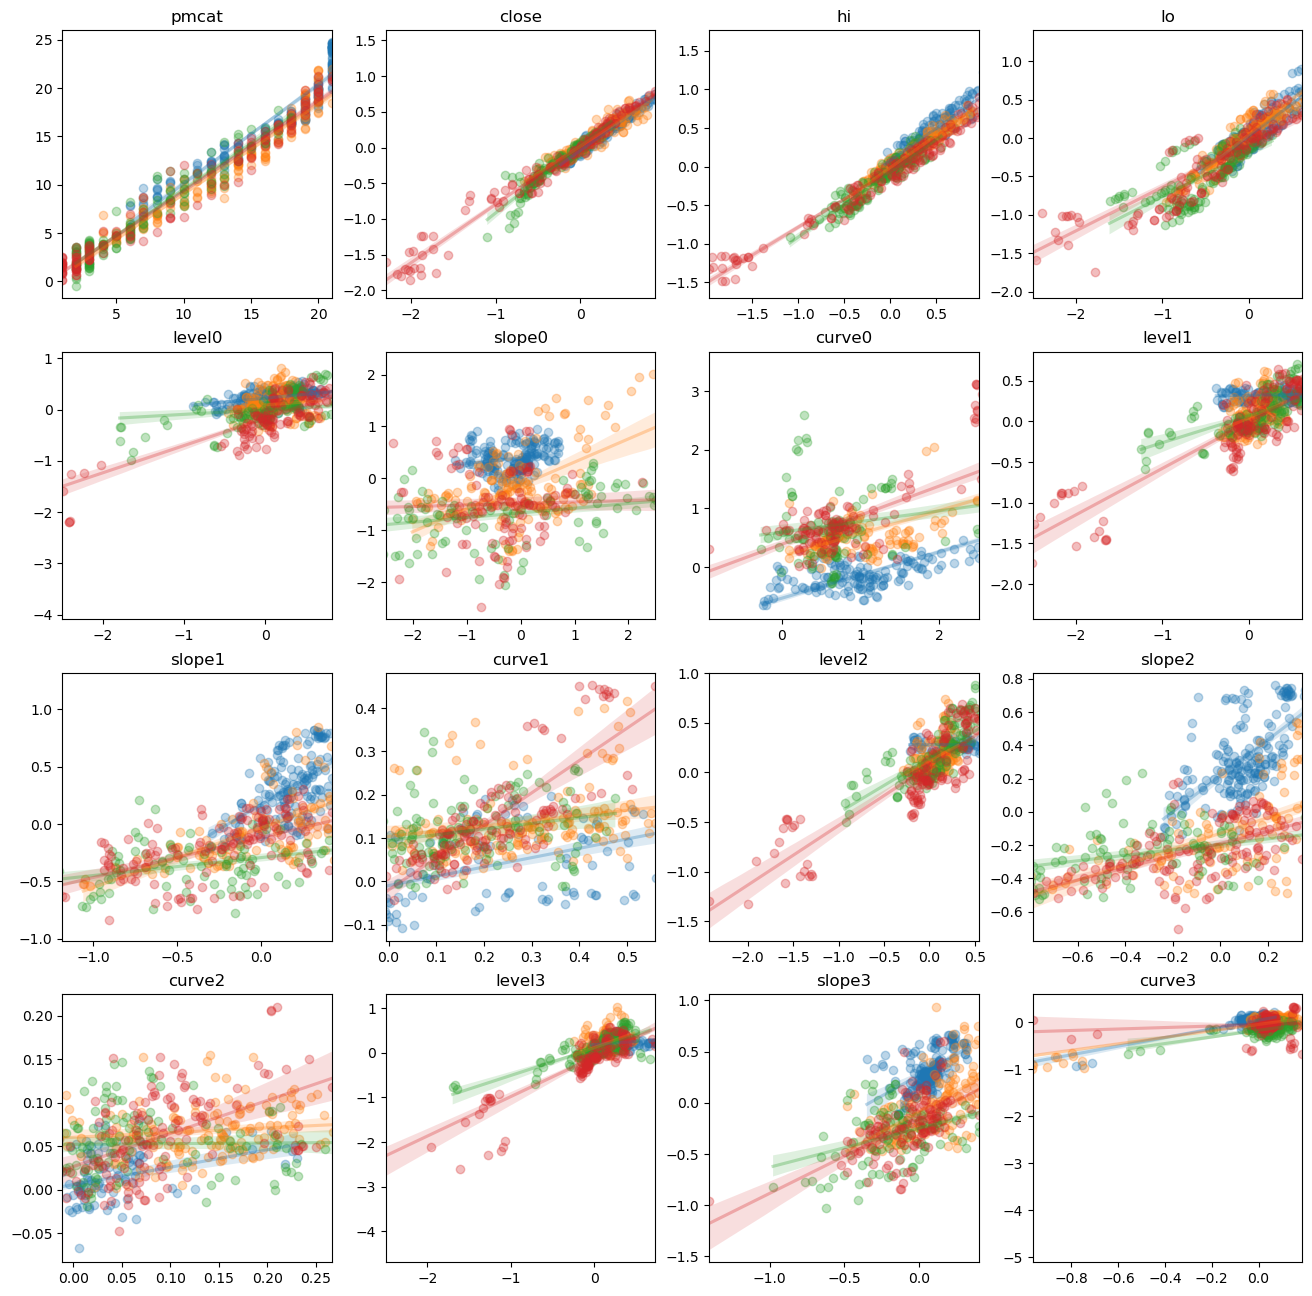

In [26]:
tables = ['volvN.csv', 'volvT.csv', 'volvA.csv', 'volvG.csv', ]
from cross_exp.exp_crossformer import Exp_crossformer
import seaborn as sns, numpy as np,math
import matplotlib.pyplot as plt
data_parser = {
    "vols": {
        'batch_size':batch_size,
        'cutday':'#2024-02-01',
    },
    }

setting=update_args(0)
exp = Exp_crossformer(args) 
print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
dep_var=['pmcat', 'close', 'hi', 'lo', 'level0', 'slope0', 'curve0', 'level1', 'slope1', 'curve1', 'level2', 'slope2', 'curve2', 'level3', 'slope3', 'curve3']
figs = min(len(dep_var), 4)
_, axes = plt.subplots(math.ceil(len(dep_var) / figs), figs, figsize=(16, 16))
results = []
for table in tables:
    results.append(exp.test(setting, True, data_path=[table], inverse=True))

for i, name in enumerate(dep_var):
    axs = axes.flat[i] if figs > 1 else axes
    for ii in range(len(tables)):
        preds, trues = results[ii]
        sns.regplot(
            ax=axs,
            x=trues[:, i],
            y=preds[:, i],
            scatter_kws={"color": f"C{ii}", "alpha": 0.3},
            line_kws={"color": f"C{ii}", "alpha": 0.3},
            label=tables[ii],
        )
    axs.set_title(name)
    mask = ~np.isnan(trues[:, i])
    if not dep_var[i][:3] in ["dtm", "pmc"]:
        axs.set_xlim(
            left=max(np.min(trues[:, i][mask]), -2.5),
            right=min(np.max(trues[:, i][mask]), 2.5),
        )
    else:
        axs.set_xlim(left=np.min(trues[:, i][mask]), right=np.max(trues[:, i][mask]))
plt.show()

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, data_dim=32, out_dim=38, d_model=256, d_ff=512, n_heads=4, e_layers=3, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type1', itr=5, save_pred=False, use_gpu=True, resume=True, cutday='#2024-02-01', gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr1<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr1/crossformer.pkl
test 188
mse:0.6805092530174961, mae:0.4664243051431308 [4.66424305e-01 6.80509253e-01 8.11147962e-01 3.62445705e+00
 5.58644682e+02 3.88297872e-01]
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr1/

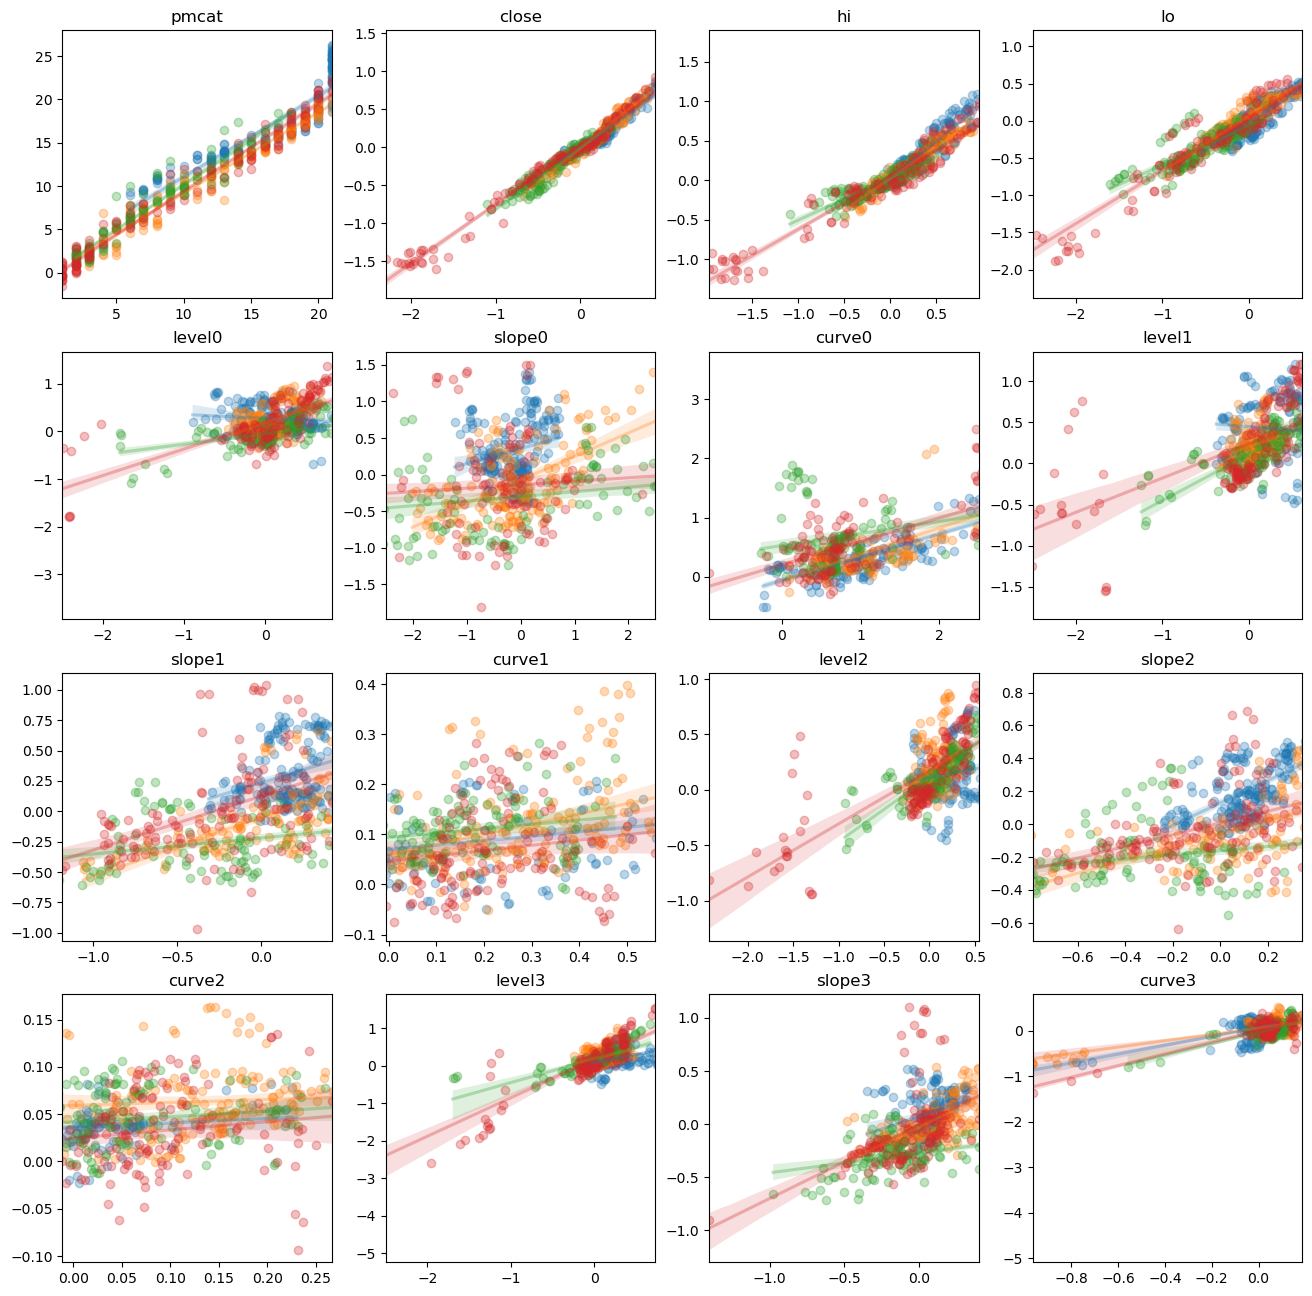

In [27]:
tables = ['volvN.csv', 'volvT.csv', 'volvA.csv', 'volvG.csv', ]
from cross_exp.exp_crossformer import Exp_crossformer
import seaborn as sns, numpy as np,math
import matplotlib.pyplot as plt
data_parser = {
    "vols": {
        'batch_size':batch_size,
        'cutday':'#2024-02-01',
    },
    }

setting=update_args(1)
exp = Exp_crossformer(args) 
print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
dep_var=['pmcat', 'close', 'hi', 'lo', 'level0', 'slope0', 'curve0', 'level1', 'slope1', 'curve1', 'level2', 'slope2', 'curve2', 'level3', 'slope3', 'curve3']
figs = min(len(dep_var), 4)
_, axes = plt.subplots(math.ceil(len(dep_var) / figs), figs, figsize=(16, 16))
results = []
for table in tables:
    results.append(exp.test(setting, True, data_path=[table], inverse=True))

for i, name in enumerate(dep_var):
    axs = axes.flat[i] if figs > 1 else axes
    for ii in range(len(tables)):
        preds, trues = results[ii]
        sns.regplot(
            ax=axs,
            x=trues[:, i],
            y=preds[:, i],
            scatter_kws={"color": f"C{ii}", "alpha": 0.3},
            line_kws={"color": f"C{ii}", "alpha": 0.3},
            label=tables[ii],
        )
    axs.set_title(name)
    mask = ~np.isnan(trues[:, i])
    if not dep_var[i][:3] in ["dtm", "pmc"]:
        axs.set_xlim(
            left=max(np.min(trues[:, i][mask]), -2.5),
            right=min(np.max(trues[:, i][mask]), 2.5),
        )
    else:
        axs.set_xlim(left=np.min(trues[:, i][mask]), right=np.max(trues[:, i][mask]))
plt.show()

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, data_dim=32, out_dim=38, d_model=256, d_ff=512, n_heads=4, e_layers=3, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type1', itr=5, save_pred=False, use_gpu=True, resume=True, cutday='#2024-02-01', gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr2<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr2/crossformer.pkl
test 188
mse:0.4511993473954818, mae:0.3863302025744226 [3.86330203e-01 4.51199347e-01 6.56144782e-01 3.40438138e+00
 7.78302969e+02 4.57446809e-01]
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr2/

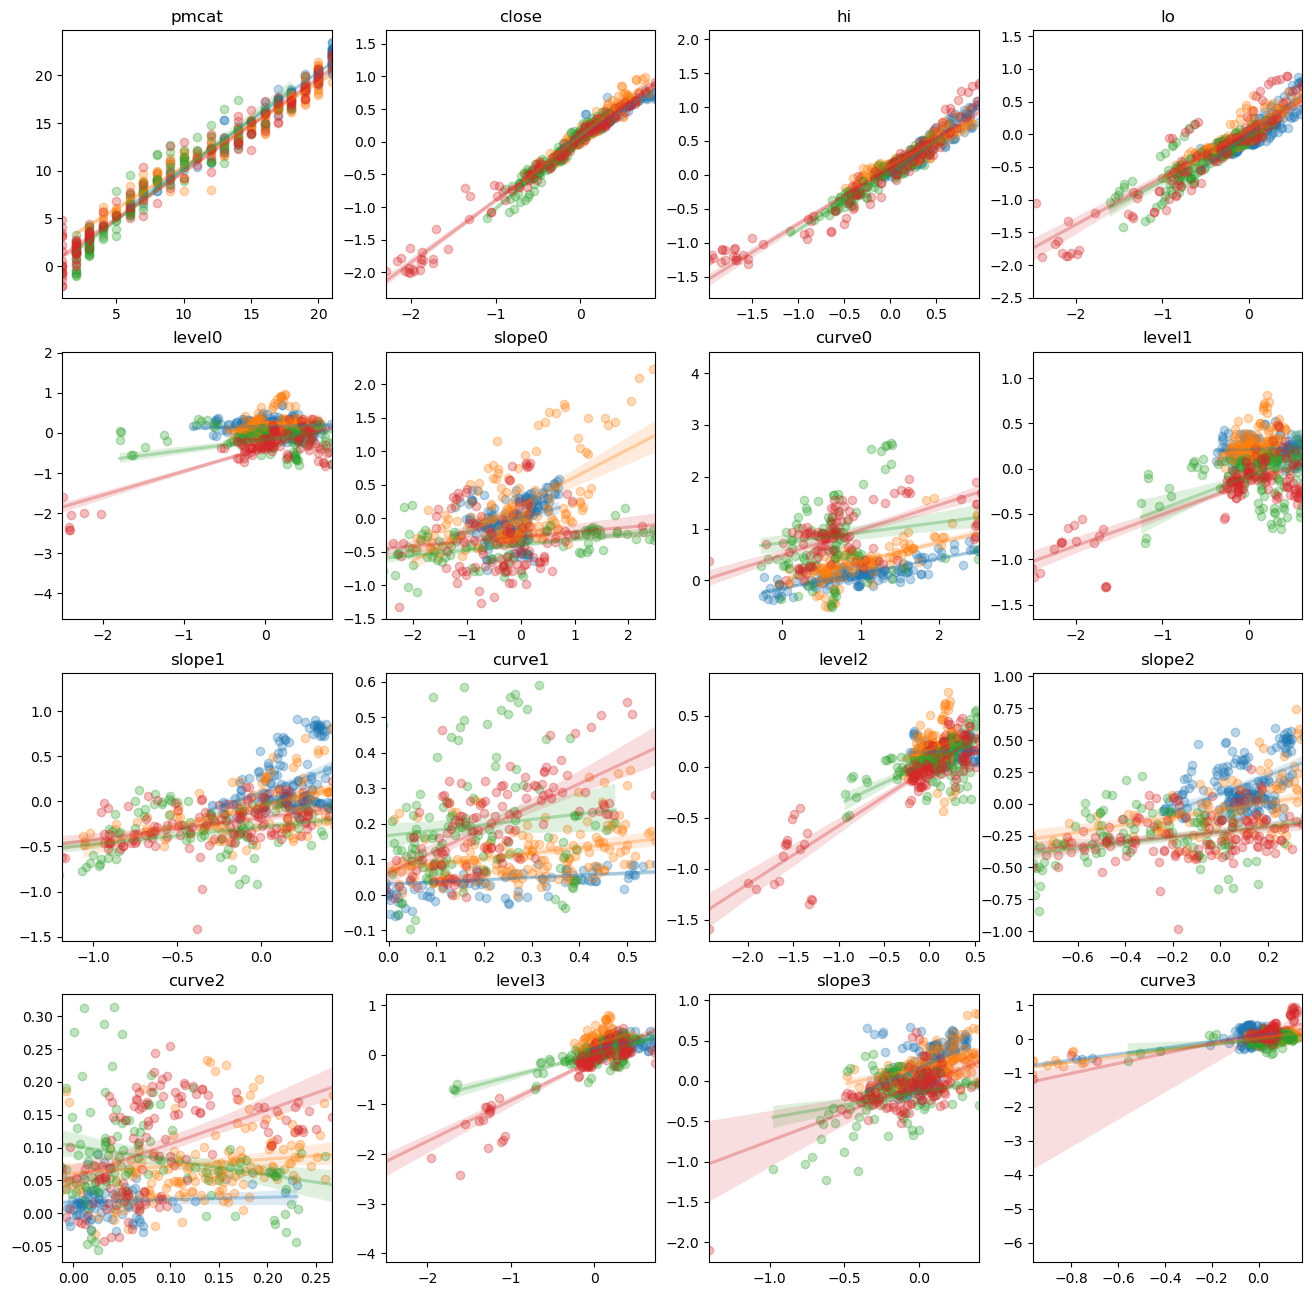

In [28]:
tables = ['volvN.csv', 'volvT.csv', 'volvA.csv', 'volvG.csv', ]
from cross_exp.exp_crossformer import Exp_crossformer
import seaborn as sns, numpy as np,math
import matplotlib.pyplot as plt
data_parser = {
    "vols": {
        'batch_size':batch_size,
        'cutday':'#2024-02-01',
    },
    }

setting=update_args(2)
exp = Exp_crossformer(args) 
print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
dep_var=['pmcat', 'close', 'hi', 'lo', 'level0', 'slope0', 'curve0', 'level1', 'slope1', 'curve1', 'level2', 'slope2', 'curve2', 'level3', 'slope3', 'curve3']
figs = min(len(dep_var), 4)
_, axes = plt.subplots(math.ceil(len(dep_var) / figs), figs, figsize=(16, 16))
results = []
for table in tables:
    results.append(exp.test(setting, True, data_path=[table], inverse=True))

for i, name in enumerate(dep_var):
    axs = axes.flat[i] if figs > 1 else axes
    for ii in range(len(tables)):
        preds, trues = results[ii]
        sns.regplot(
            ax=axs,
            x=trues[:, i],
            y=preds[:, i],
            scatter_kws={"color": f"C{ii}", "alpha": 0.3},
            line_kws={"color": f"C{ii}", "alpha": 0.3},
            label=tables[ii],
        )
    axs.set_title(name)
    mask = ~np.isnan(trues[:, i])
    if not dep_var[i][:3] in ["dtm", "pmc"]:
        axs.set_xlim(
            left=max(np.min(trues[:, i][mask]), -2.5),
            right=min(np.max(trues[:, i][mask]), 2.5),
        )
    else:
        axs.set_xlim(left=np.min(trues[:, i][mask]), right=np.max(trues[:, i][mask]))
plt.show()

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, data_dim=32, out_dim=38, d_model=256, d_ff=512, n_heads=4, e_layers=3, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type1', itr=5, save_pred=False, use_gpu=True, resume=True, cutday='#2024-02-01', gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr3<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr3/crossformer.pkl
test 188
mse:0.5003811402820345, mae:0.4038103461856224 [4.03810346e-01 5.00381140e-01 7.01570675e-01 4.79280993e+00
 1.38037908e+03 4.09574468e-01]
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr3/

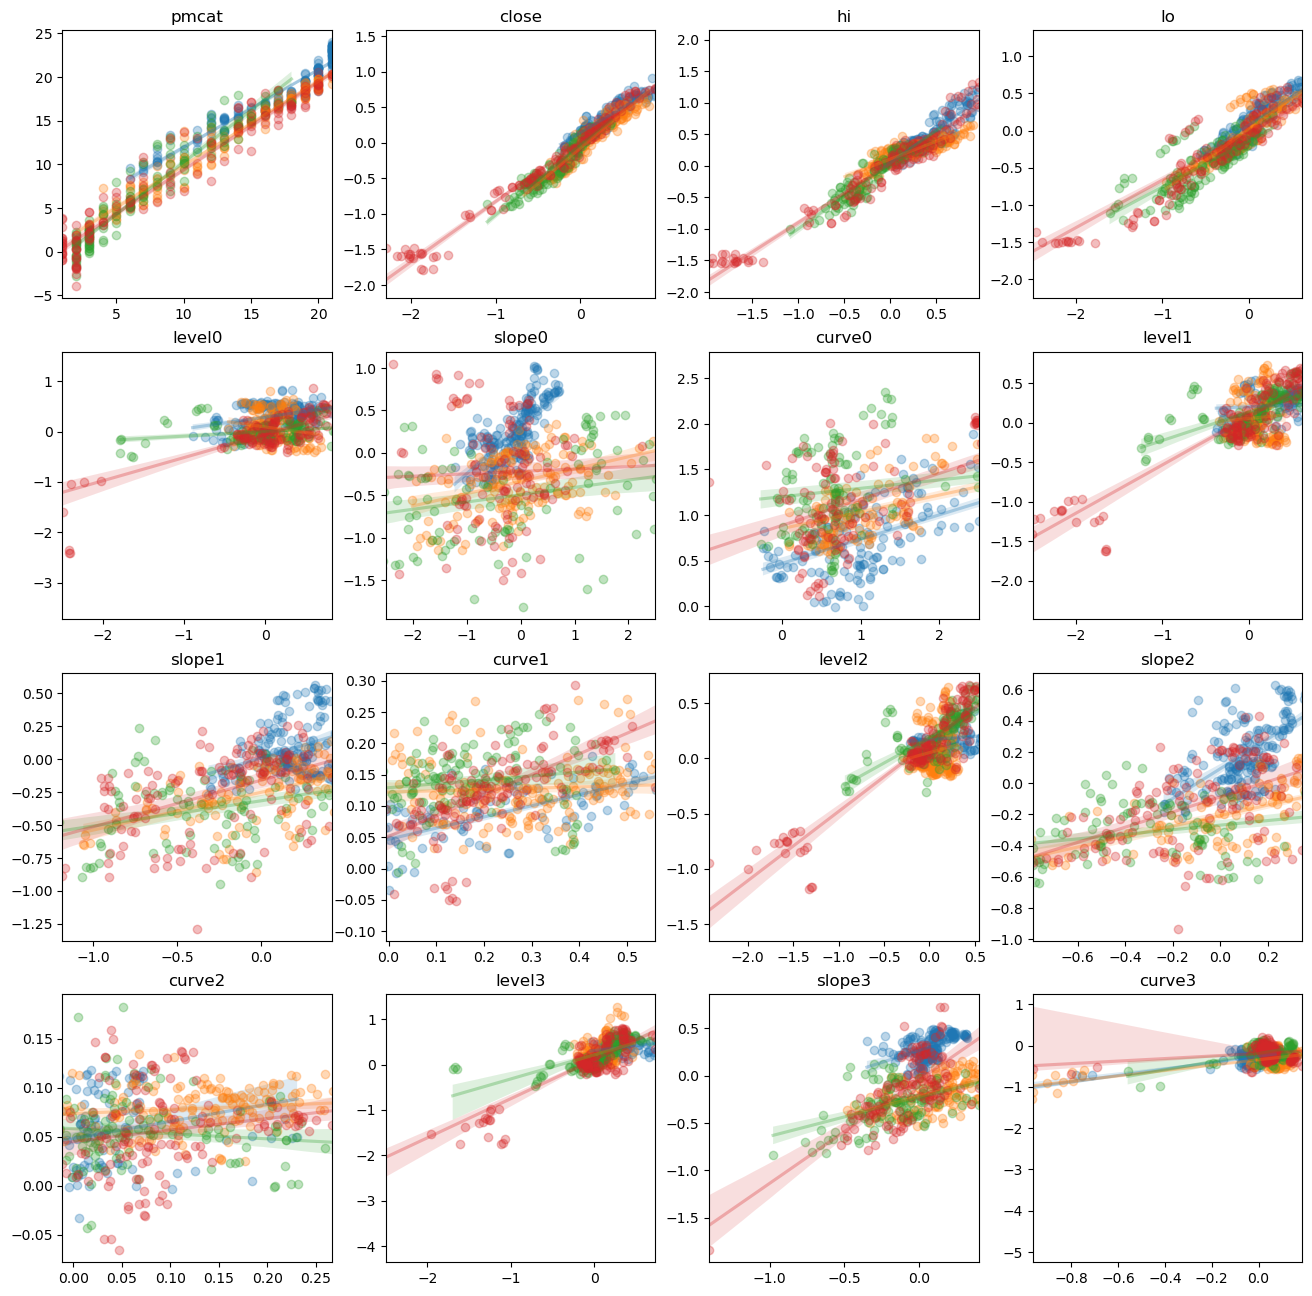

In [29]:
tables = ['volvN.csv', 'volvT.csv', 'volvA.csv', 'volvG.csv', ]
from cross_exp.exp_crossformer import Exp_crossformer
import seaborn as sns, numpy as np,math
import matplotlib.pyplot as plt
data_parser = {
    "vols": {
        'batch_size':batch_size,
        'cutday':'#2024-02-01',
    },
    }

setting=update_args(3)
exp = Exp_crossformer(args) 
print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
dep_var=['pmcat', 'close', 'hi', 'lo', 'level0', 'slope0', 'curve0', 'level1', 'slope1', 'curve1', 'level2', 'slope2', 'curve2', 'level3', 'slope3', 'curve3']
figs = min(len(dep_var), 4)
_, axes = plt.subplots(math.ceil(len(dep_var) / figs), figs, figsize=(16, 16))
results = []
for table in tables:
    results.append(exp.test(setting, True, data_path=[table], inverse=True))

for i, name in enumerate(dep_var):
    axs = axes.flat[i] if figs > 1 else axes
    for ii in range(len(tables)):
        preds, trues = results[ii]
        sns.regplot(
            ax=axs,
            x=trues[:, i],
            y=preds[:, i],
            scatter_kws={"color": f"C{ii}", "alpha": 0.3},
            line_kws={"color": f"C{ii}", "alpha": 0.3},
            label=tables[ii],
        )
    axs.set_title(name)
    mask = ~np.isnan(trues[:, i])
    if not dep_var[i][:3] in ["dtm", "pmc"]:
        axs.set_xlim(
            left=max(np.min(trues[:, i][mask]), -2.5),
            right=min(np.max(trues[:, i][mask]), 2.5),
        )
    else:
        axs.set_xlim(left=np.min(trues[:, i][mask]), right=np.max(trues[:, i][mask]))
plt.show()

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, data_dim=32, out_dim=38, d_model=256, d_ff=512, n_heads=4, e_layers=3, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type1', itr=5, save_pred=False, use_gpu=True, resume=True, cutday='#2024-02-17', gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr0/crossformer.pkl
test 106
mse:0.7229024322942933, mae:0.4643480173036962 [  0.46434802   0.72290243   0.84383107   2.39936244 163.78581799
   0.25471698]
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr0/crossformer.

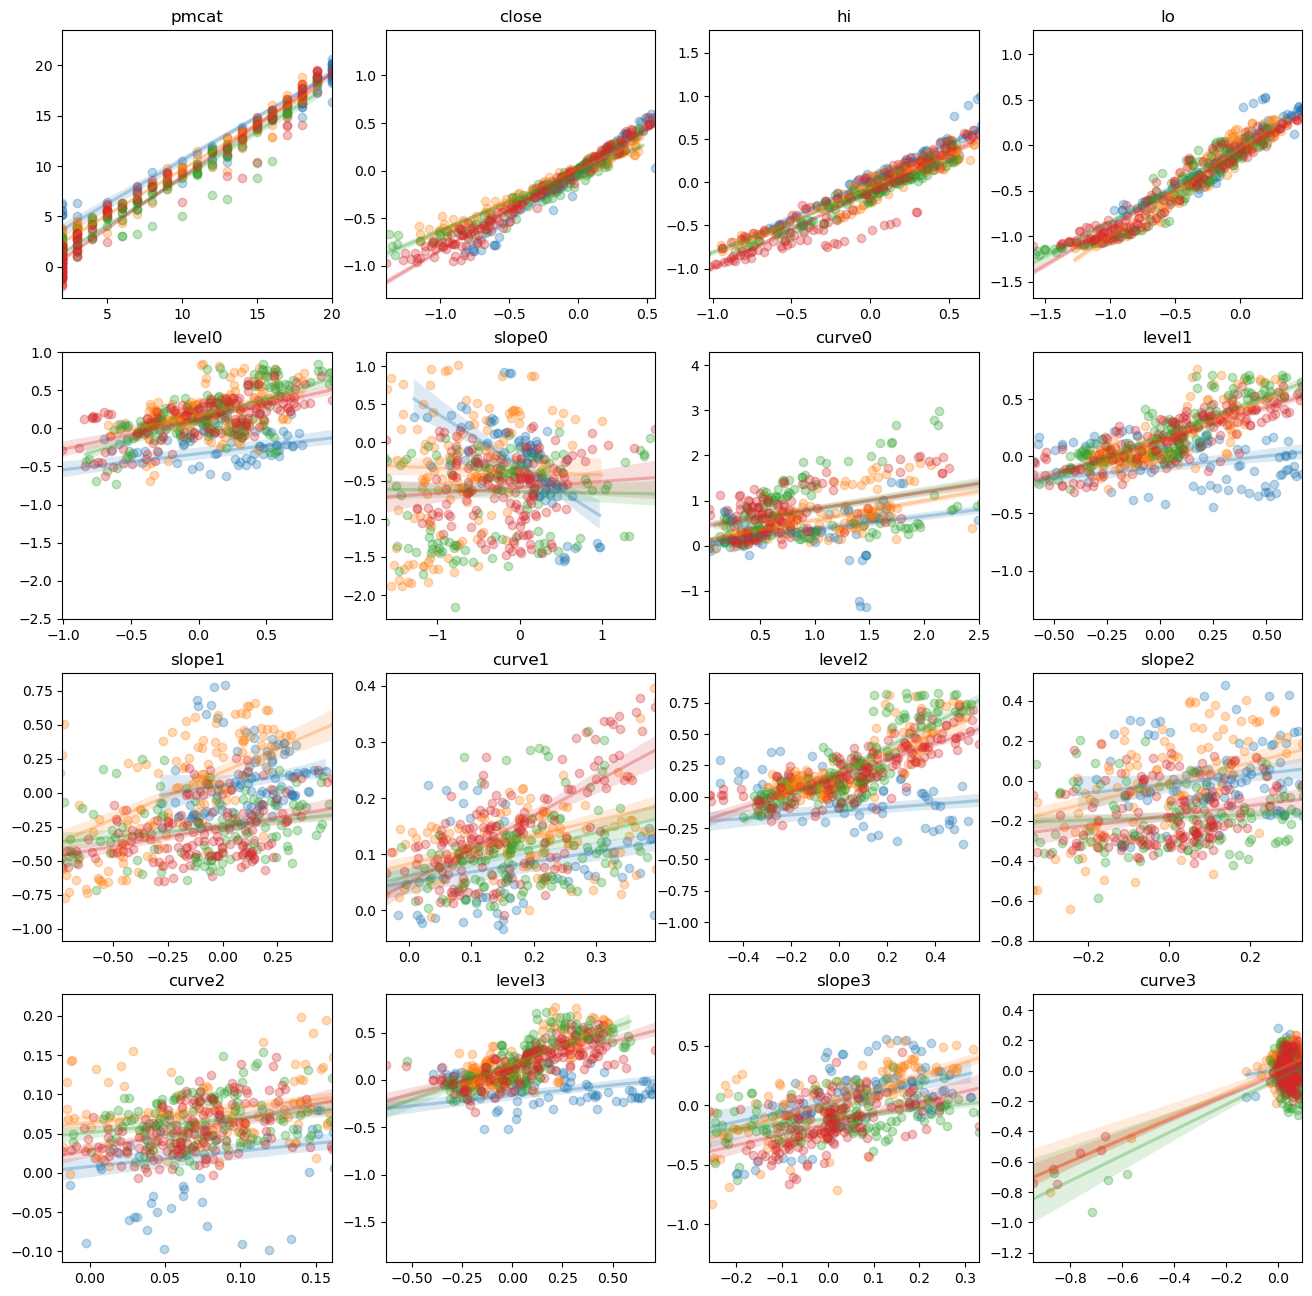

In [2]:
tables = ['volvN.csv', 'volvT.csv', 'volvA.csv', 'volvG.csv', ]
from cross_exp.exp_crossformer import Exp_crossformer
import seaborn as sns, numpy as np,math
import matplotlib.pyplot as plt
data_parser = {
    "vols": {
        'batch_size':batch_size,
        'cutday':'#2024-02-17',
    },
    }

setting=update_args(0)
exp = Exp_crossformer(args) 
print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
dep_var=['pmcat', 'close', 'hi', 'lo', 'level0', 'slope0', 'curve0', 'level1', 'slope1', 'curve1', 'level2', 'slope2', 'curve2', 'level3', 'slope3', 'curve3']
figs = min(len(dep_var), 4)
_, axes = plt.subplots(math.ceil(len(dep_var) / figs), figs, figsize=(16, 16))
results = []
for table in tables:
    results.append(exp.test(setting, True, data_path=[table], inverse=True))

for i, name in enumerate(dep_var):
    axs = axes.flat[i] if figs > 1 else axes
    for ii in range(len(tables)):
        preds, trues = results[ii]
        sns.regplot(
            ax=axs,
            x=trues[:, i],
            y=preds[:, i],
            scatter_kws={"color": f"C{ii}", "alpha": 0.3},
            line_kws={"color": f"C{ii}", "alpha": 0.3},
            label=tables[ii],
        )
    axs.set_title(name)
    mask = ~np.isnan(trues[:, i])
    if not dep_var[i][:3] in ["dtm", "pmc"]:
        axs.set_xlim(
            left=max(np.min(trues[:, i][mask]), -2.5),
            right=min(np.max(trues[:, i][mask]), 2.5),
        )
    else:
        axs.set_xlim(left=np.min(trues[:, i][mask]), right=np.max(trues[:, i][mask]))
plt.show()

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, data_dim=32, out_dim=38, d_model=256, d_ff=512, n_heads=4, e_layers=3, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type1', itr=5, save_pred=False, use_gpu=True, resume=True, cutday='#2024-02-17', gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr1<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr1/crossformer.pkl
test 106
mse:0.6356705507774767, mae:0.43540566456132435 [4.35405665e-01 6.35670551e-01 7.92631478e-01 3.13018246e+00
 1.31977513e+03 4.05660377e-01]
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr1

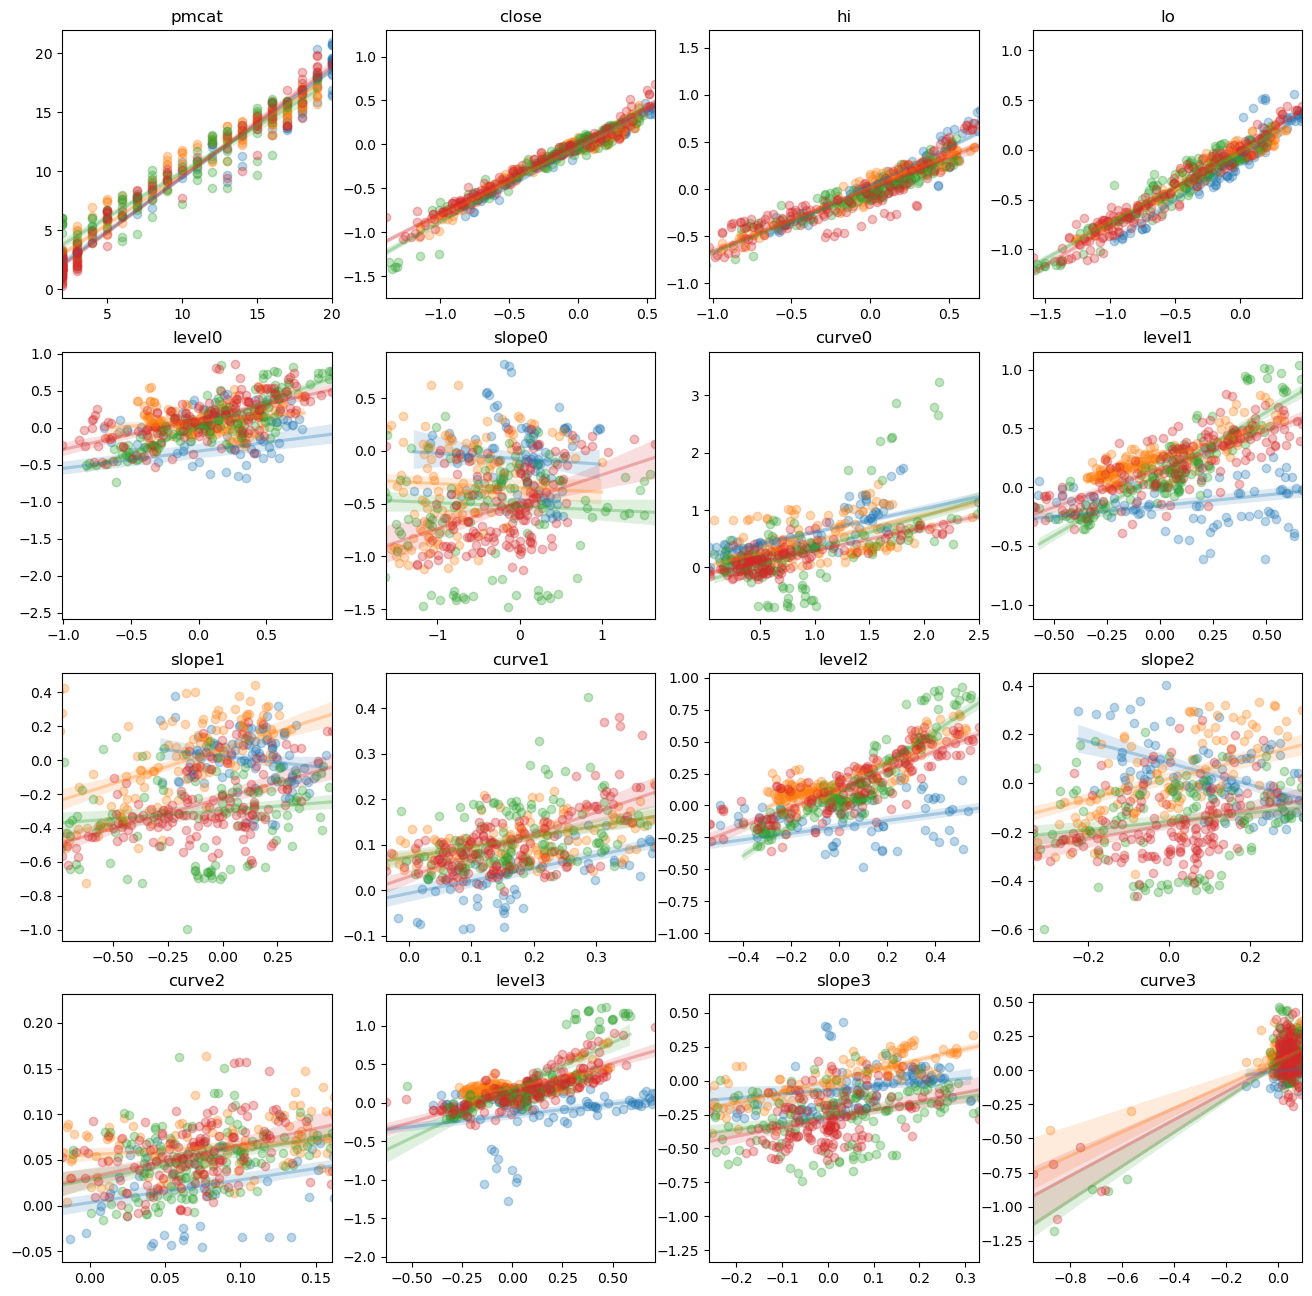

In [3]:
tables = ['volvN.csv', 'volvT.csv', 'volvA.csv', 'volvG.csv', ]
from cross_exp.exp_crossformer import Exp_crossformer
import seaborn as sns, numpy as np,math
import matplotlib.pyplot as plt
data_parser = {
    "vols": {
        'batch_size':batch_size,
        'cutday':'#2024-02-17',
    },
    }

setting=update_args(1)
exp = Exp_crossformer(args) 
print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
dep_var=['pmcat', 'close', 'hi', 'lo', 'level0', 'slope0', 'curve0', 'level1', 'slope1', 'curve1', 'level2', 'slope2', 'curve2', 'level3', 'slope3', 'curve3']
figs = min(len(dep_var), 4)
_, axes = plt.subplots(math.ceil(len(dep_var) / figs), figs, figsize=(16, 16))
results = []
for table in tables:
    results.append(exp.test(setting, True, data_path=[table], inverse=True))

for i, name in enumerate(dep_var):
    axs = axes.flat[i] if figs > 1 else axes
    for ii in range(len(tables)):
        preds, trues = results[ii]
        sns.regplot(
            ax=axs,
            x=trues[:, i],
            y=preds[:, i],
            scatter_kws={"color": f"C{ii}", "alpha": 0.3},
            line_kws={"color": f"C{ii}", "alpha": 0.3},
            label=tables[ii],
        )
    axs.set_title(name)
    mask = ~np.isnan(trues[:, i])
    if not dep_var[i][:3] in ["dtm", "pmc"]:
        axs.set_xlim(
            left=max(np.min(trues[:, i][mask]), -2.5),
            right=min(np.max(trues[:, i][mask]), 2.5),
        )
    else:
        axs.set_xlim(left=np.min(trues[:, i][mask]), right=np.max(trues[:, i][mask]))
plt.show()

Args in experiment:
Namespace(data='vols', root_path='E:/mydoc/git/trade/analyics/', data_path=['volvA.csv'], data_split=[0.7, 0.1, 0.2], checkpoints='./checkpoints/', in_len=20, out_len=1, seg_len=5, win_size=2, factor=10, data_dim=32, out_dim=38, d_model=256, d_ff=512, n_heads=4, e_layers=3, dropout=0.2, baseline=False, num_workers=0, batch_size=32, train_epochs=20, patience=3, learning_rate=0.0001, lradj='type1', itr=5, save_pred=False, use_gpu=True, resume=True, cutday='#2024-02-17', gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use GPU: cuda:0
>>>>>>>testing : Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr2<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr2/crossformer.pkl
test 106
mse:0.8215089235484851, mae:0.49038071444443593 [4.90380714e-01 8.21508924e-01 8.95786455e-01 3.59984458e+00
 7.76796920e+02 5.66037736e-01]
suc to load ./checkpoints/Crossformer_vols_il20_ol1_sl5_win2_fa10_dm256_nh4_el3_itr2

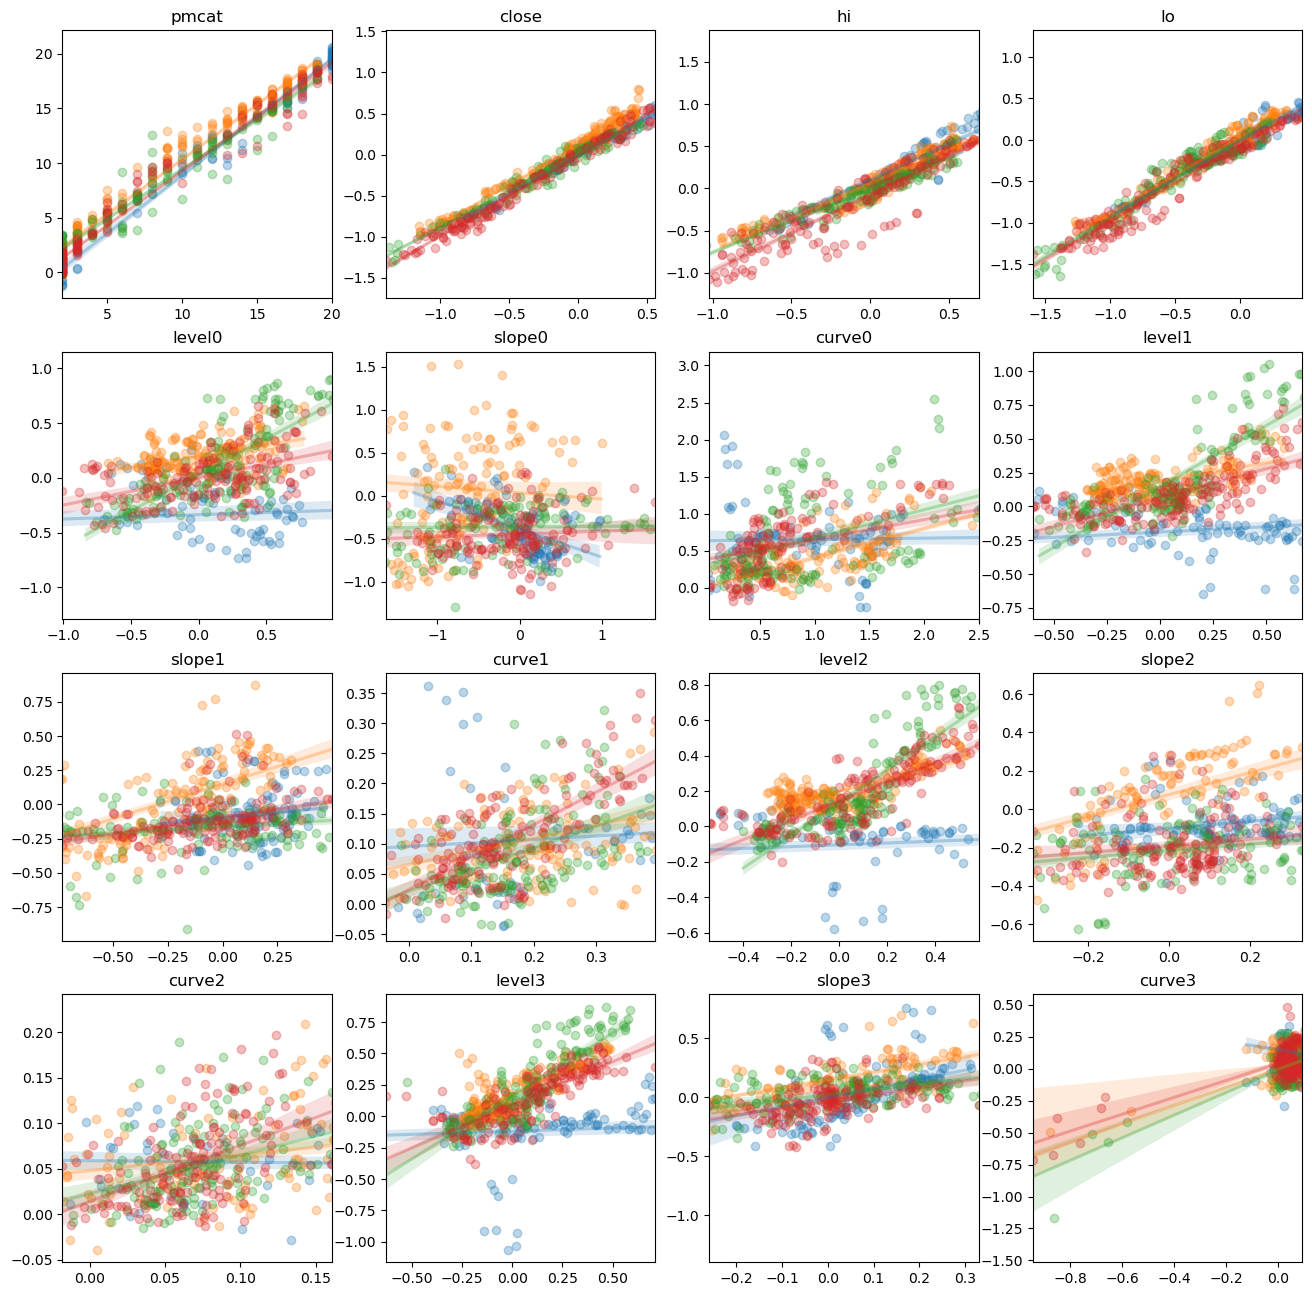

In [4]:
tables = ['volvN.csv', 'volvT.csv', 'volvA.csv', 'volvG.csv', ]
from cross_exp.exp_crossformer import Exp_crossformer
import seaborn as sns, numpy as np,math
import matplotlib.pyplot as plt
data_parser = {
    "vols": {
        'batch_size':batch_size,
        'cutday':'#2024-02-17',
    },
    }

setting=update_args(2)
exp = Exp_crossformer(args) 
print(f">>>>>>>testing : {setting}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
dep_var=['pmcat', 'close', 'hi', 'lo', 'level0', 'slope0', 'curve0', 'level1', 'slope1', 'curve1', 'level2', 'slope2', 'curve2', 'level3', 'slope3', 'curve3']
figs = min(len(dep_var), 4)
_, axes = plt.subplots(math.ceil(len(dep_var) / figs), figs, figsize=(16, 16))
results = []
for table in tables:
    results.append(exp.test(setting, True, data_path=[table], inverse=True))

for i, name in enumerate(dep_var):
    axs = axes.flat[i] if figs > 1 else axes
    for ii in range(len(tables)):
        preds, trues = results[ii]
        sns.regplot(
            ax=axs,
            x=trues[:, i],
            y=preds[:, i],
            scatter_kws={"color": f"C{ii}", "alpha": 0.3},
            line_kws={"color": f"C{ii}", "alpha": 0.3},
            label=tables[ii],
        )
    axs.set_title(name)
    mask = ~np.isnan(trues[:, i])
    if not dep_var[i][:3] in ["dtm", "pmc"]:
        axs.set_xlim(
            left=max(np.min(trues[:, i][mask]), -2.5),
            right=min(np.max(trues[:, i][mask]), 2.5),
        )
    else:
        axs.set_xlim(left=np.min(trues[:, i][mask]), right=np.max(trues[:, i][mask]))
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()